<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            86 non-null     int64  
 1    Population     86 non-null     int64  
 2    Annual Change  85 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 2.1 KB
None
              date    Population   Annual Change
count    86.000000  8.600000e+01       85.000000
mean   1992.500000  3.361721e+06        0.105176
std      24.969982  1.748144e+05        0.833096
min    1950.000000  3.041000e+06       -0.870000
25%    1971.250000  3.233250e+06       -0.240000
50%    1992.500000  3.389000e+06        0.070000
75%    2013.750000  3.497750e+06        0.190000
max    2035.000000  3.639000e+06        5.750000
date              0
 Population       0
 Annual Change    1
dtype: int64


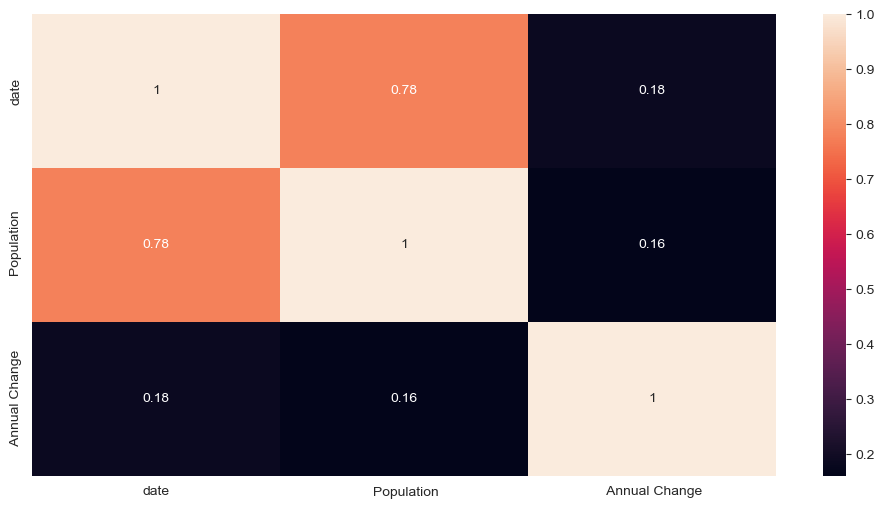

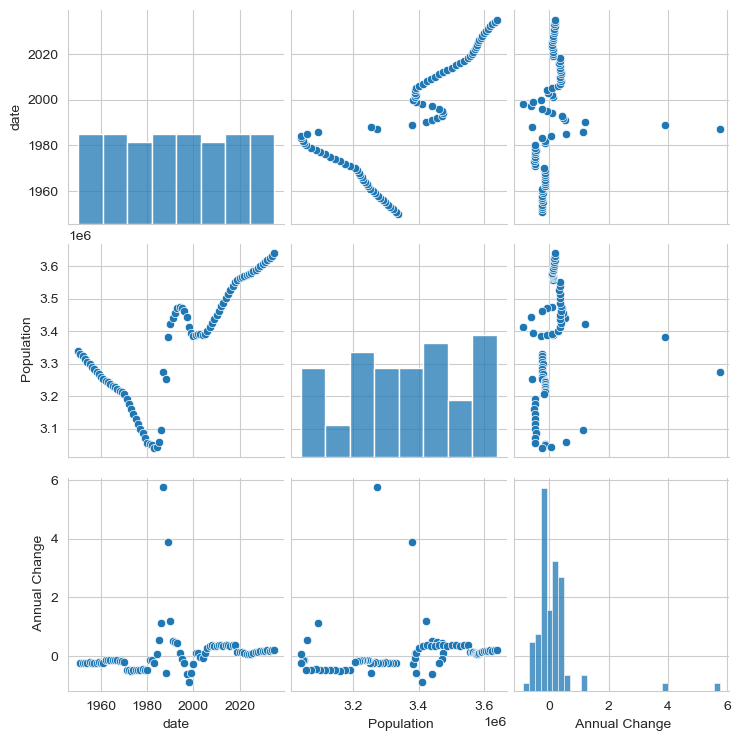

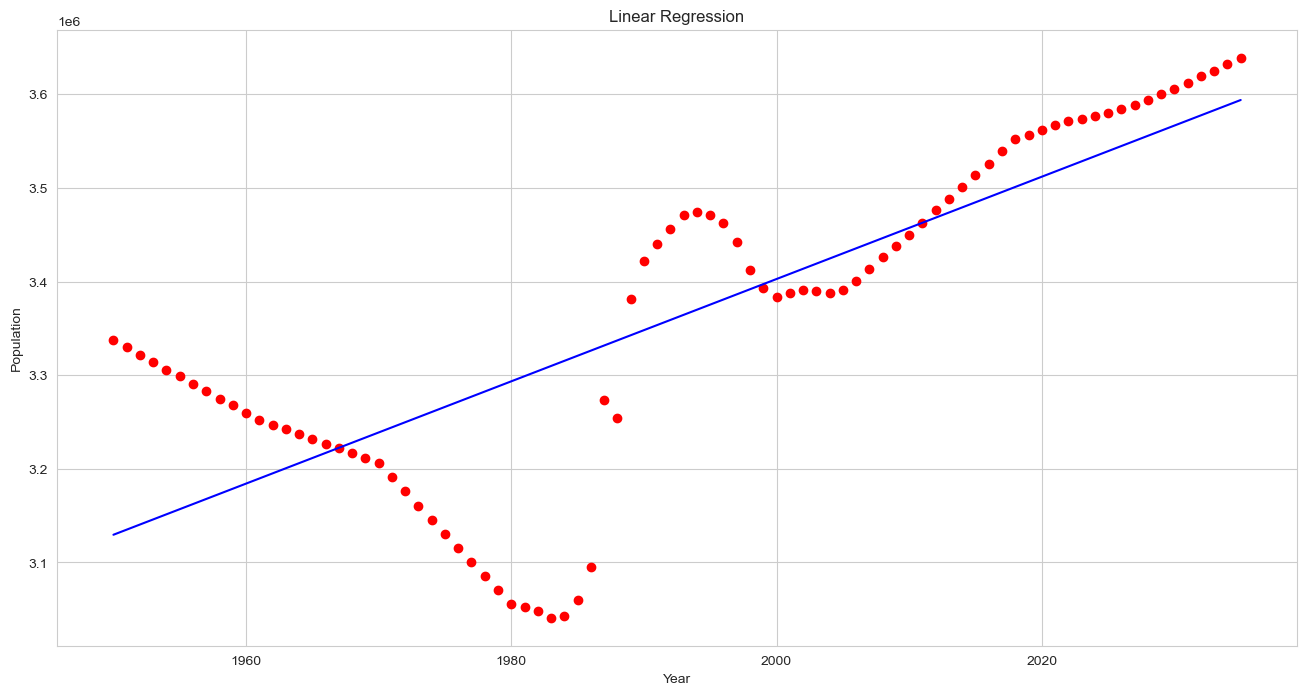

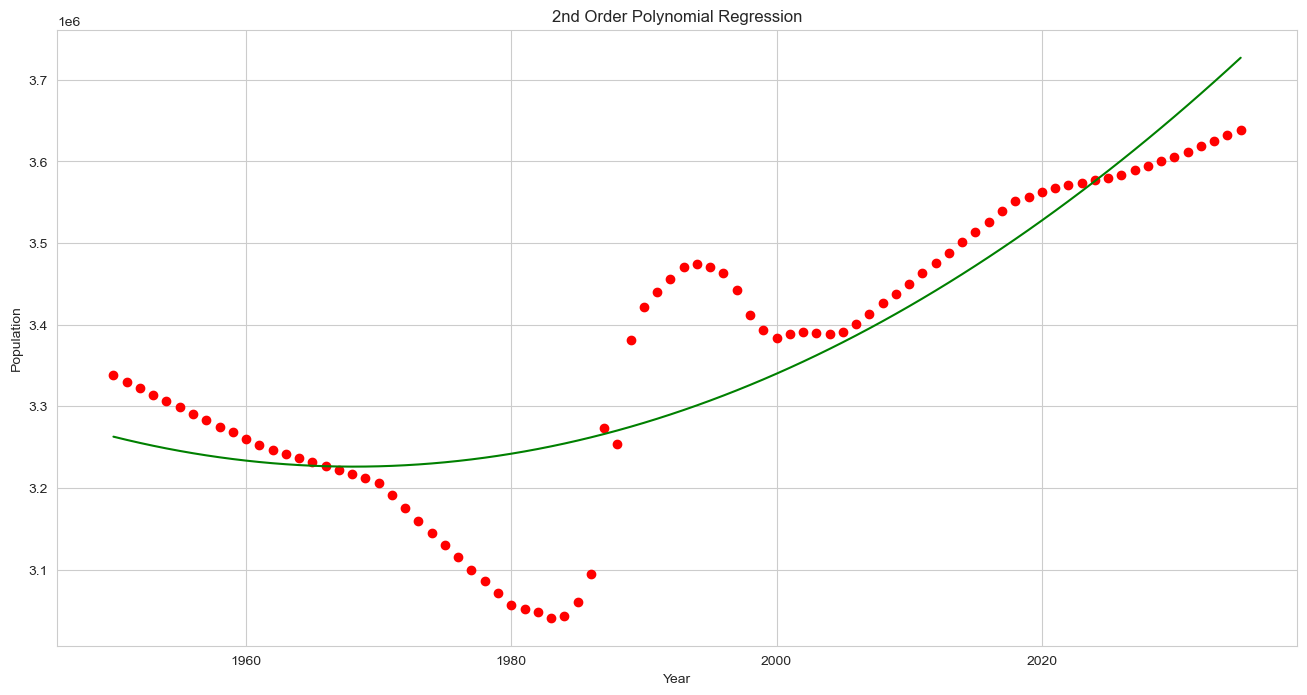

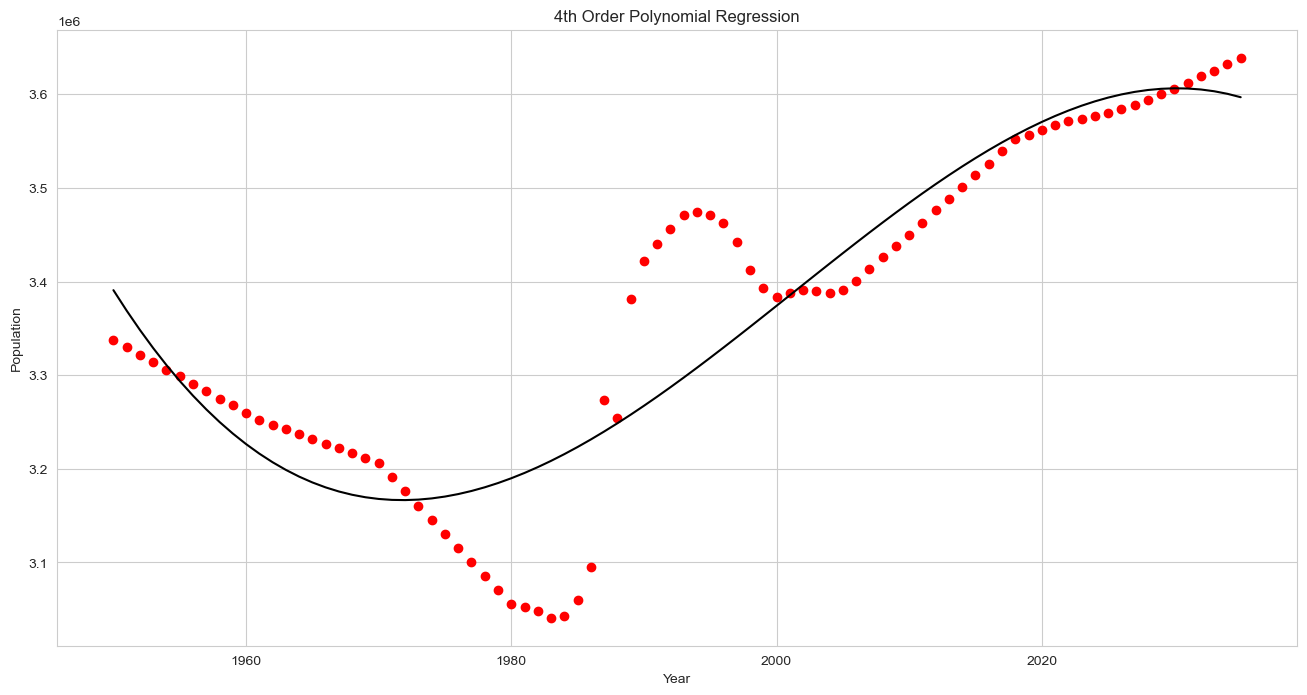


Population Predictions in Tananarivo in 2035:
Linear Regression:
[[3593846.83239776]]

Polinomal Regression(degree=2):
[[3727080.32005322]]

Polinomal Regression(degree=4):
[[3596823.26821899]]


R² Values of the Regressions:

Linear R² value
0.6086274988056017

Polynomial R² value(degree=2)
0.7346609389955037

Polynomial R² value(degree=4)
0.8253115107228721


ModuleNotFoundError: No module named 'keras'

In [17]:

"""
Created on Wed Feb 17 00:17:18 2023

@author: Diriana Tiney

"""


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
import time


start = time.time()
df = pd.read_csv('Tananarivo-population-2020-12-30.csv')
print(df.info())
print(df.describe())
print(df.isnull().sum())


plt.figure(figsize = (12, 6))
sns.heatmap(df.corr(), annot = True)
sns.pairplot(df)
plt.show()


x = df.iloc[:, 0:1] 
y = df.iloc[:, 1:2]


X = x.values
Y = y.values



from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, Y)

plt.figure(figsize=(16, 8))
plt.scatter(X, Y, color='red')
plt.plot(x, lin_reg.predict(X), color = 'blue')
plt.title('Linear Regression')
plt.xlabel('Year')
plt.ylabel('Population')
sns.set_style("whitegrid")
plt.show()


from sklearn.preprocessing import PolynomialFeatures
poly_reg2 = PolynomialFeatures(degree = 2)
x_poly2 = poly_reg2.fit_transform(X)
lin_reg2 = LinearRegression()
lin_reg2.fit(x_poly2, y)
# Plotting 2nd Order Polynomial
plt.figure(figsize=(16, 8))
plt.scatter(X, Y, color = 'red')
plt.plot(X, lin_reg2.predict(poly_reg2.fit_transform(X)), color = 'green')
plt.title('2nd Order Polynomial Regression')
plt.xlabel('Year')
plt.ylabel('Population')
plt.show()


poly_reg4 = PolynomialFeatures(degree = 4)
x_poly4 = poly_reg4.fit_transform(X)
lin_reg4 = LinearRegression()
lin_reg4.fit(x_poly4, y)
plt.figure(figsize=(16, 8))
# Plotting 4th Order Polynomial 
plt.scatter(X, Y, color = 'red')
plt.plot(X, lin_reg4.predict(poly_reg4.fit_transform(X)), color='black')
plt.title('4th Order Polynomial Regression')
plt.xlabel('Year')
plt.ylabel('Population')
plt.show()



print('\nPopulation Predictions in Tananarivo in 2035:')
print("Linear Regression:")
print(lin_reg.predict([[2035]]))

print("\nPolinomal Regression(degree=2):")
print(lin_reg2.predict(poly_reg2.fit_transform([[2035]])))

print("\nPolinomal Regression(degree=4):")
print(lin_reg4.predict(poly_reg4.fit_transform([[2035]])))



print('\n\nR² Values of the Regressions:\n')
print('Linear R² value')
print(r2_score(Y, lin_reg.predict(X)))

print('\nPolynomial R² value(degree=2)')
print(r2_score(Y, lin_reg2.predict(poly_reg2.fit_transform(X))))

print('\nPolynomial R² value(degree=4)')
print(r2_score(Y, lin_reg4.predict(poly_reg4.fit_transform(X))))



from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Making DataFrame
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=['date',
                                                             ' Population'])
for i in range(0, len(data)):
    new_data['date'][i] = data['date'][i]
    new_data[' Population'][i] = data[' Population'][i]


new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)


dataset = new_data.values



train = dataset[0:61, :]
valid = dataset[60:72, :]


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60, len(train)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, 
               input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=32, batch_size=1, verbose=2)


inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
population_Pred = model.predict(X_test)
population_Pred = scaler.inverse_transform(population_Pred)

rms=np.sqrt(np.mean(np.power((valid-population_Pred), 2)))
print(f"RMS(Difference between actual population and predicted population): {rms}")


plt.figure(figsize=(16, 8))
train = new_data[:61]
valid = new_data[60:72]
valid['Predictions'] = population_Pred

plt.axis([2007, 2023, 3400000, 3800000])
plt.title('Tananarivo Population Prediction', fontsize=18)
plt.xlabel('Years', fontsize=18)
plt.ylabel(' Population', fontsize = 18)
plt.plot(train[' Population'])
plt.plot(valid[[' Population', 'Predictions']])
plt.legend(["Train Dataset", "Tananarivo Actual Population", "tananarivo Predicted Population"])
plt.show()

end = time.time()
cal_time = end - start
print("\nProcess took {} seconds.".format(cal_time))
